# Дескрипторы

Методы, основанные на выделении особых точек для распознавания тестового изображения. 

Алгоритм работы методов поиска особых точек включает два этапа: 

1) обнаружение особых точек;
2) сопоставление особых точек.

Особые точки — такие точки, по которым можно классифицировать изображение, распознать его, некая особенность изображения, уникальность. Как правило — это угловые точки, либо те, где резко меняется цвет, яркость, и т. д. Нужно выбирать такие точки, которые вносят некий вклад в характеристику изображения, также необходимо считать особыми такие точки, которые с большой вероятностью будут найдены на другом изображении.[1]

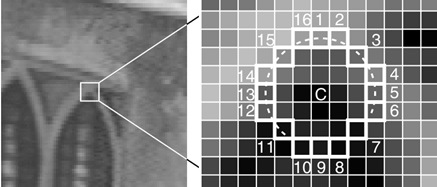

Для обеспечения надежного распознавания важно, чтобы особые точки, извлеченные из тестового изображения, можно было затем обнаружить даже при изменении масштаба изображения, незначительного изменения ракурса съемки, зашумленности и освещенности. Такие точки обычно лежат на высококонтрастных областях изображения.
 
Важно также учесть, чтобы относительное расстояние между выделенными на изображении точками не менялось при переходе с одного кадра на другой. 



## Детектор углов Харриса

Алгоритм обнаружения углов Харриса - один из простейших детекторов углов. Идея заключается в том, чтобы найти особые точки, в окрестности которых имеются границы в нескольких направлениях, это и есть угловые точки.

Определим положительно-полуопределённую симметричную матрицу $M_I=M_I(\textbf{x})$, где $\textbf{x}$ - точка внутри изображения:

$$M_I=\nabla I \,\nabla I^T=\begin{pmatrix}I_x \\ I_y\end{pmatrix} \begin{pmatrix}I_x & I_y \end{pmatrix}=\begin{pmatrix}I_x^2 & I_x I_y \\ I_x I_y & I_y^2\end{pmatrix}$$

По построению $M_I$ имеет ранг 1, а её собственные значения равны $\lambda_1=\left|\nabla I\right|^2$ и $\lambda_2=0$.

Таким образом, имеется по одной матрице для каждой точки изображения.

Введём матрицу весов $W$ (обычно = фильтр Гаусса $G_\sigma$). Операция поэлементной свёртки

$$\overline{M}_I=W*M_I$$

даёт локальное усреднение $M_I$ по соседним пикселям. Получающаяся матрица $\overline{M}_I$ - матрица Харриса. Ширина $W$ определяет размер окрестности $\textbf{x}$, представляющей интерес.

Смысл усреднения матрицы $M_I$ по области состоит в том, что собственные значения будут изменятся в зависимости от локальных свойств изображения. Если градиенты в этой области меняются, то второе собственное значение $\overline{M}_I$ не будет равно 0. Если же градиенты одинаковы, то собственные значения будут такими же, как у $M_I$.

В зависимости от значений градиента в области возможны 3 случая ($\lambda_1$ и $\lambda_2$ - собственные значения матрицы Харриса $\overline{M}_I$):
- $\lambda_1$ и $\lambda_2$ - большие положительные числа $\Rightarrow$ в точке $\textbf{x}$ имеется угол
- $\lambda_1$ велико, а $\lambda_2\approx 0$ $\Rightarrow$ существует граница; при усреднении $M_I$ по области её собственные значения изменяются не сильно
- $\lambda_1\approx\lambda_2\approx 0$ $\Rightarrow$ в точке нет никаких особенностей

Чтобы отличить существенный случай от остальных, Харрис и Стивенс ввели индикаторную функцию:

$$\det{\overline{M}_I}-\kappa\,\mathrm{tr}{\overline{M}_I}$$

Чтобы избавится от весовой постоянной $\kappa$, в качестве индикатора удобно использовать частное:

$$\frac{\det{\overline{M}_I}}{\mathrm{tr}{\overline{M}_I}}$$

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Загрузка цветного изображения
image = cv2.imread('HOUSE.jpg')

# Применение детектора углов Харриса требует преобразования в оттенки серого
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Применение детектора углов Харриса
dst = cv2.cornerHarris(gray, blockSize=2, ksize=3, k=0.04)

# Пороговое значение для выделения углов
threshold = 0.01 * dst.max()

# Создание изображения, на котором будут отмечены углы
corner_image = np.copy(image)

# Отмечаем найденные углы на изображении
corner_image[dst > threshold] = [0, 0, 255]  # Красный цвет для углов

# Отображение изображения с отмеченными углами с помощью Matplotlib
plt.imshow(cv2.cvtColor(corner_image, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Отключение осей координат
plt.show()


error: OpenCV(4.8.1) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


## Нахождение соответственных точек на изображениях

Для нахождения соответственных точек на изображениях необходимо снабдить каждую особую точку Харриса дескриптором и предложить способ сравнения дескрипторов.

**Дескриптор особой точки** - это сопоставленный точке вектор, который описывает окрестность этой точки на изображении. Чем лучше дескриптор, тем качественнее будет соответствие.

Угловые точки Харриса обычно комбинируются с дескриптором, состоящим из значений яркости в окружающем блоке изображения и нормированной взаимной корреляции.

В общем случае корреляция между двумя блоками изображения одинакового размера $I_1$ и $I_2$ определяется как

$$c(I_1, I_2)=\sum_{\textbf{x}}f\!\left(I_1(\textbf{x}), I_2(\textbf{x})\right),$$

где $f$ зависит от метода вычисления корреляции. Суммирование производится по всем точкам $\textbf{x}$ в блоке изображения.

В случае **взаимной корреляции** в качестве $f$ берётся функция $f(I_1, I_2)=I_1I_2$.

**Нормированная взаимная корреляция** - это вариант взаимной корреляции, который определяется следующим образом:

$$\mathrm{ncc}\left(I_1, I_2\right)=\frac{1}{n-1}\sum_{x}\frac{I_1(\textbf{x})-\mu_1}{\sigma_1}\frac{I_2(\textbf{x})-\mu_2}{\sigma_2},$$

где $n$ - число пикселей в блоке, $\mu_1$ и $\mu_2$ - средние яркости, а $\sigma_1$ и $\sigma_2$ - стандартные отклонения в каждом блоке.

Благодаря вычитанию средних и нормировке на стандартное отклонение этот метод слабо чувствителен к изменению яркости изображения.

In [8]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Загрузка изображений
image1 = cv2.imread('left.jpg')
image2 = cv2.imread('right.jpg')

# Преобразование изображений в оттенки серого
gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

# Создание объекта дескриптора SIFT
sift = cv2.SIFT_create()

# Поиск ключевых точек и дескрипторов особенностей на изображениях
keypoints1, descriptors1 = sift.detectAndCompute(gray1, None)
keypoints2, descriptors2 = sift.detectAndCompute(gray2, None)

# Создание объекта BFMatcher
bf = cv2.BFMatcher()

# Сопоставление дескрипторов особенностей с помощью метода KNN
matches = bf.knnMatch(descriptors1, descriptors2, k=2)

# Применение метода RANSAC для фильтрации сопоставлений
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# Ограничение количества совпадений до 50
good_matches = good_matches[:50]

# Отрисовка сопоставленных точек на изображениях
matching_image = cv2.drawMatches(image1, keypoints1, image2, keypoints2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Конвертация изображения из BGR в RGB для использования с Matplotlib
matching_image_rgb = cv2.cvtColor(matching_image, cv2.COLOR_BGR2RGB)

# Отображение изображения с отмеченными соответствиями с помощью Matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(matching_image_rgb)
plt.axis('off')
plt.show()




error: OpenCV(4.8.1) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


## SIFT (масштабно-инвариантная трансформация признаков)

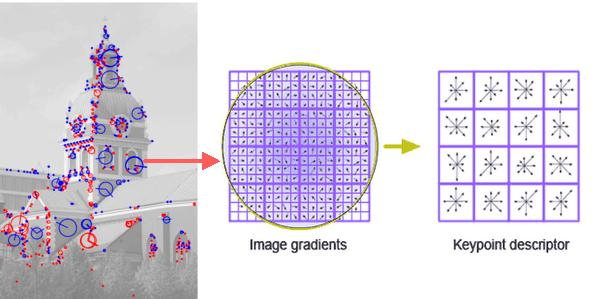


**Методы SIFT** (Scale-Invariant feature transform — масштабно-инвариантная трансформация признаков) и SURF (Speeded-Up Robust Features — ускоренные
устойчивые признаки) содержат детекторы для определения интересующих нас характерных точек на изображении и отбрасывании низкоконтрастных ключевых точек. 

Выходной величиной в обоих случаях является представление соседней с характерной точкой области в виде вектора дескрипторов.


1. Ивашечкин, А. П. Методы нахождения особых точек изображения и их дескрипторов / А. П. Ивашечкин, А. Ю. Василенко, Б. Д. Гончаров. — Текст : непосредственный // Молодой ученый. — 2016. — № 15 (119). — С. 138-140. — URL: https://moluch.ru/archive/119/33106/ (дата обращения: 20.02.2024).


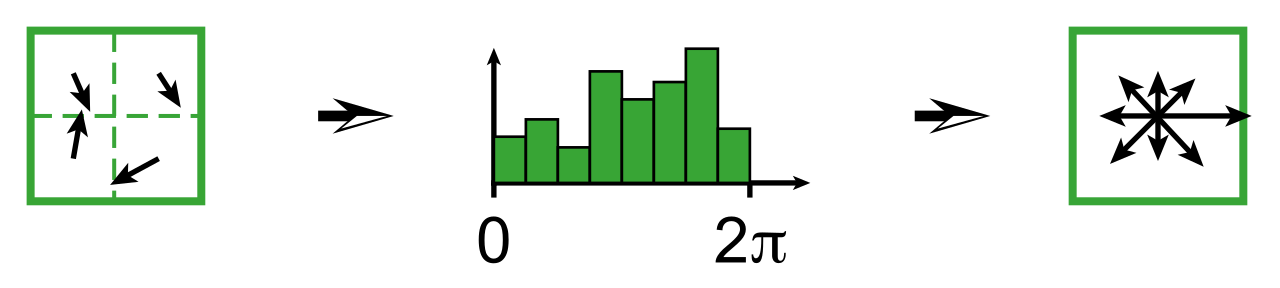

## Библиотеки для работы

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy import stats
import sys


# 1. Классический случай: Сопоставление двух изображений

In [10]:
rgb_l  = cv2.cvtColor(cv2.imread("left.jpg"), cv2.COLOR_BGR2RGB)
gray_l = cv2.cvtColor(rgb_l, cv2.COLOR_RGB2GRAY)
rgb_r  = cv2.cvtColor(cv2.imread("right.jpg"), cv2.COLOR_BGR2RGB)
gray_r = cv2.cvtColor(rgb_r, cv2.COLOR_RGB2GRAY)

error: OpenCV(4.8.1) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [11]:
# use orb if sift is not installed
feature_extractor = cv2.SIFT_create()

# find the keypoints and descriptors with chosen feature_extractor
kp_l, desc_l = feature_extractor.detectAndCompute(gray_l, None)
kp_r, desc_r = feature_extractor.detectAndCompute(gray_r, None)

test = cv2.drawKeypoints(rgb_l, kp_l, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

figsize = (20, 20)
plt.figure(figsize=figsize)
plt.imshow(test)
plt.title("keypoints")
plt.show()

NameError: name 'gray_l' is not defined

In [12]:
bf = cv2.BFMatcher()
matches = bf.knnMatch(desc_l, desc_r, k=2)


good_match = []
for m in matches:
    if m[0].distance/m[1].distance < 0.5:
        good_match.append(m)
good_match_arr = np.asarray(good_match)

# показать 30 точек
im_matches = cv2.drawMatchesKnn(rgb_l, kp_l, rgb_r, kp_r,
                                good_match[0:30], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(20, 20))
plt.imshow(im_matches)
plt.title("keypoints matches")
plt.show()



NameError: name 'desc_l' is not defined

# 2. Пример на коровах

## Датасет

Этот датасет состоит из 80 изображений коров. Они представляют собой цветные изображения размером 200 x 400 пикселей.

In [14]:
def num2fixstr(x,d):
  # example num2fixstr(2,5) returns '00002'
  # example num2fixstr(19,3) returns '019'
  st = '%0*d' % (d,x)
  return st

def ImageLoad(prefix,num_img,echo='off'):
  st   = prefix + num2fixstr(num_img,5) + '.png'
  if echo == 'on':
    print('loading image '+st+'...')

  img = cv2.cvtColor(cv2.imread(st), cv2.COLOR_BGR2RGB)
  return img


## Визуализация

loading image cows_dataset/V00008.png...


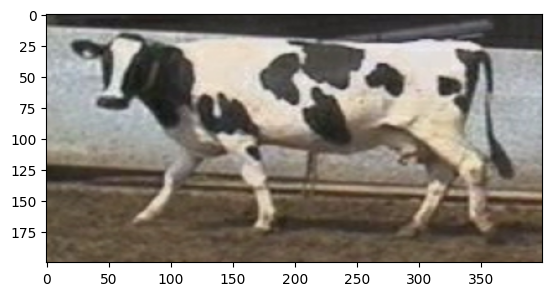

In [15]:
I = ImageLoad('cows_dataset/V',8,echo='on')
plt.imshow(I,cmap='gray')
plt.show()

Сделаем продвинутый способ визуализации **ipywidgets**

Расширения Jupyter ipywidgets - это интерактивная записная книжка HTML-виджетов Jupyter. Пакет позволяет вам создать виджет для управления вашими данными через интерактивный графический интерфейс, такой как ползунок, флажки, текстовое поле и многое другое. Это очень полезно, если мы хотим создать визуализацию на основе графического интерфейса пользователя в Jupyter Notebook вручную.

([Гайд по ккнопкам](https://scmax.ru/articles/1314/))

In [17]:
from ipywidgets import interact

def show_image(prefix, num_img):
    I = ImageLoad(prefix, num_img, echo='on')
    plt.imshow(I, cmap='gray')
    plt.axis('off')  # отключение осей
    plt.show()

# Пример использования с ipywidgets interact
interact(show_image, prefix='cows_dataset/V', num_img=(1, 80))

interactive(children=(Text(value='cows_dataset/V', description='prefix'), IntSlider(value=40, description='num…

<function __main__.show_image(prefix, num_img)>

## Извлечение дескрипторов SIFT

Из всех ключевых точек каждого изображения извлекается 128-элементный дескриптор SIFT. Обычно на каждом изображении присутствует около 400-500 ключевых точек. В данном примере все ключевые точки, их количество составляет 35910, хранятся в массиве X размером 35910 x 128 элементов. Кроме того, каждый дескриптор хранится в нормализованной форме (с нормой = 1). Одновременно номер изображения, из которого была извлечена ключевая точка, хранится в векторе y из 35910 элементов. То есть этот вектор содержит номера от 0 до 79, соответствующие номерам изображений.

In [18]:
t = 0
Xt = np.zeros((50000,128))
yt = np.zeros((50000,))

N = 80

for i in range(N):
  I = ImageLoad('cows_dataset/V',i+1,echo='on')
  J = cv2.cvtColor(I, cv2.COLOR_RGB2GRAY)
  # SIFT extraction
  kp, desc = feature_extractor.detectAndCompute(J, None)
  ni = desc.shape[0]
  for j in range(ni):
    f = desc[j,:]
    Xt[t,:] =  f/np.linalg.norm(f)
    yt[t] = i
    t = t+1

  print('... '+str(ni)+' Дескрипторы были извлечены.')

X = Xt[0:t,:]
y = yt[0:t]
print('Количество дескрипторов SIFT в '+str(N)+' images: '+str(t))

loading image cows_dataset/V00001.png...
... 424 Дескрипторы были извлечены.
loading image cows_dataset/V00002.png...
... 404 Дескрипторы были извлечены.
loading image cows_dataset/V00003.png...
... 338 Дескрипторы были извлечены.
loading image cows_dataset/V00004.png...
... 492 Дескрипторы были извлечены.
loading image cows_dataset/V00005.png...
... 406 Дескрипторы были извлечены.
loading image cows_dataset/V00006.png...
... 469 Дескрипторы были извлечены.
loading image cows_dataset/V00007.png...
... 460 Дескрипторы были извлечены.
loading image cows_dataset/V00008.png...
... 442 Дескрипторы были извлечены.
loading image cows_dataset/V00009.png...
... 459 Дескрипторы были извлечены.
loading image cows_dataset/V00010.png...
... 418 Дескрипторы были извлечены.
loading image cows_dataset/V00011.png...
... 544 Дескрипторы были извлечены.
loading image cows_dataset/V00012.png...
... 490 Дескрипторы были извлечены.
loading image cows_dataset/V00013.png...
... 357 Дескрипторы были извлечены.

## Тестирование

Производится поиск изображения, наиболее похожего на изображение itest, то есть изображения (кроме тестового), содержащего наибольшее количество дескрипторов SIFT, схожих с дескрипторами тестового изображения.

C:\Users\UserPC\AppData\Local\Temp\ipykernel_7088\3107968021.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d[k] = yj[j]           # это номер изображения, к которому принадлежит ближайший дескриптор обучения


loading image cows_dataset/V00004.png...
Тестовое изображение: 4


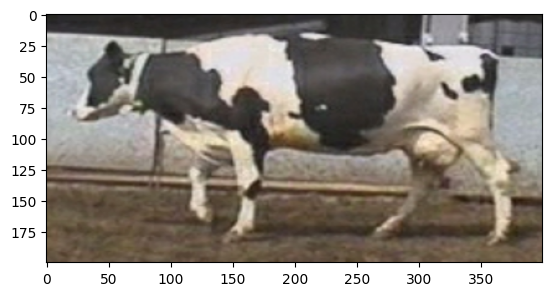

 
loading image cows_dataset/V00005.png...
Для изображения 4, наиболее похожее изображение: 5.


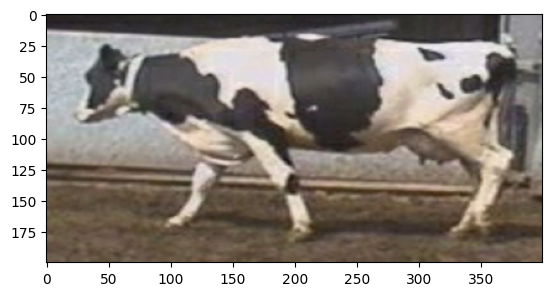

--------------------------------------------------
loading image cows_dataset/V00014.png...
Тестовое изображение: 14


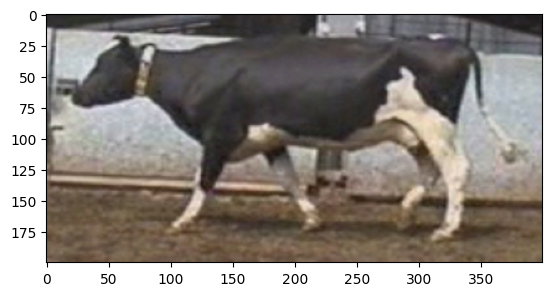

 
loading image cows_dataset/V00015.png...
Для изображения 14, наиболее похожее изображение: 15.


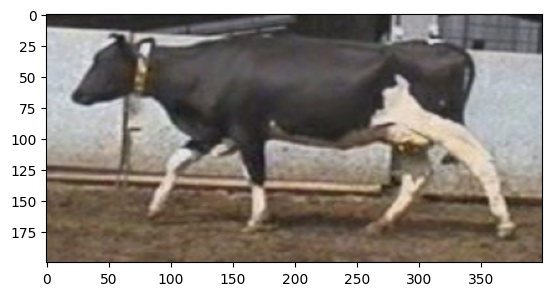

--------------------------------------------------
loading image cows_dataset/V00024.png...
Тестовое изображение: 24


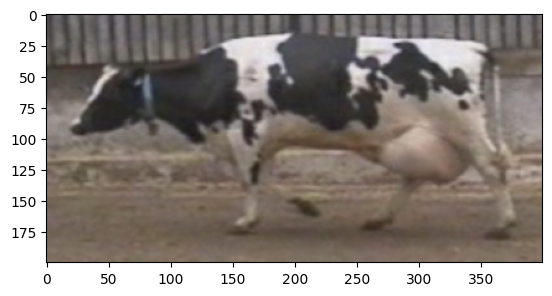

 
loading image cows_dataset/V00023.png...
Для изображения 24, наиболее похожее изображение: 23.


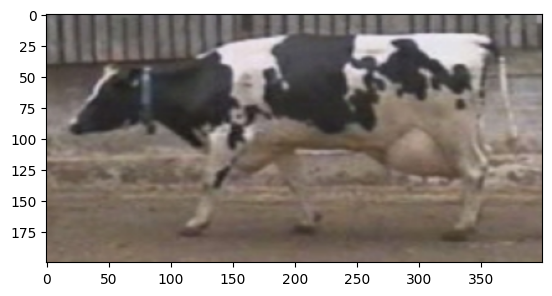

--------------------------------------------------
loading image cows_dataset/V00034.png...
Тестовое изображение: 34


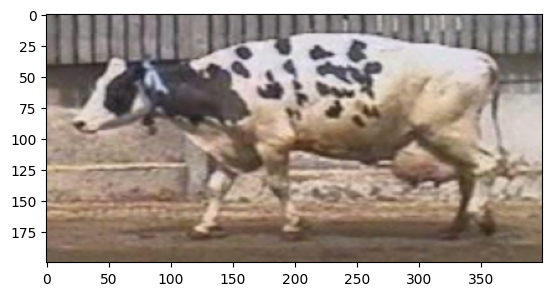

 
loading image cows_dataset/V00035.png...
Для изображения 34, наиболее похожее изображение: 35.


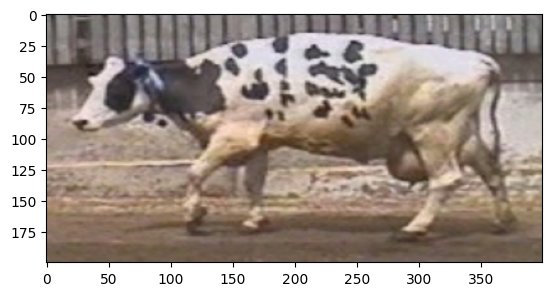

--------------------------------------------------
loading image cows_dataset/V00044.png...
Тестовое изображение: 44


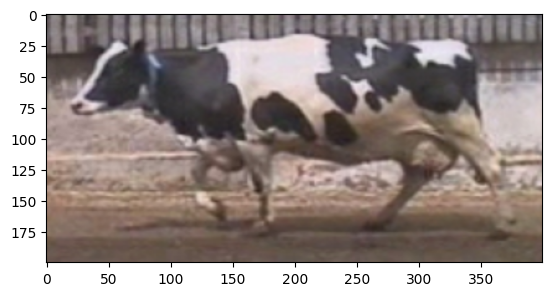

 
loading image cows_dataset/V00043.png...
Для изображения 44, наиболее похожее изображение: 43.


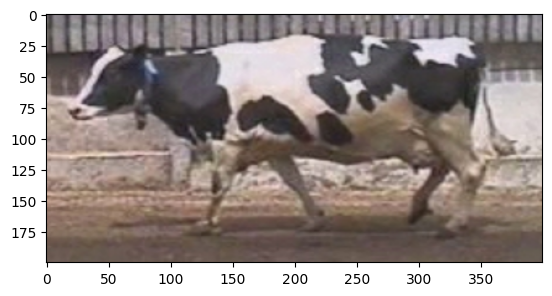

--------------------------------------------------
loading image cows_dataset/V00054.png...
Тестовое изображение: 54


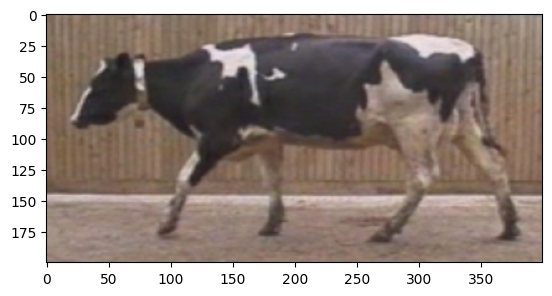

 
loading image cows_dataset/V00055.png...
Для изображения 54, наиболее похожее изображение: 55.


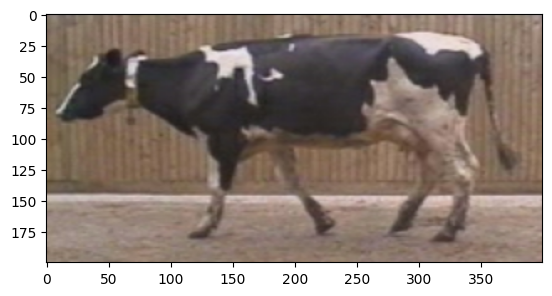

--------------------------------------------------
loading image cows_dataset/V00064.png...
Тестовое изображение: 64


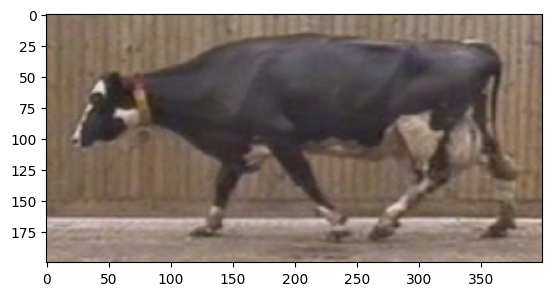

 
loading image cows_dataset/V00065.png...
Для изображения 64, наиболее похожее изображение: 65.


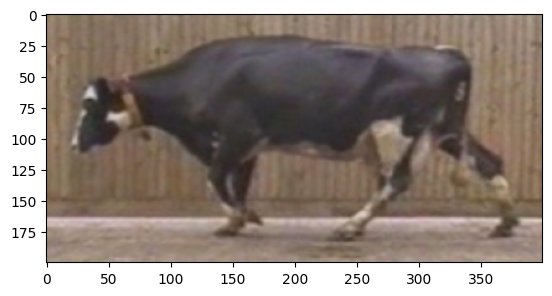

--------------------------------------------------
loading image cows_dataset/V00074.png...
Тестовое изображение: 74


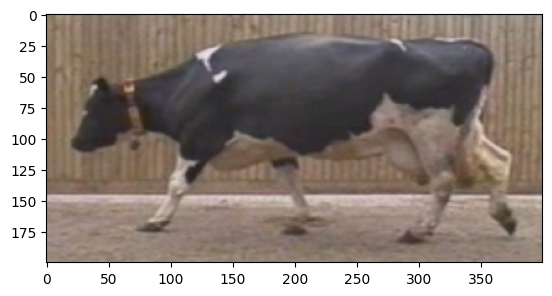

 
loading image cows_dataset/V00070.png...
Для изображения 74, наиболее похожее изображение: 70.


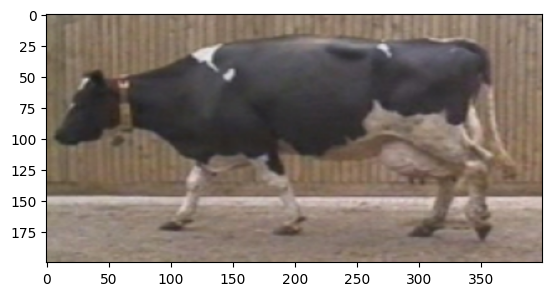

--------------------------------------------------


In [19]:
for itest in [4,14,24,34,44,54,64,74]:
    ik = itest - 1  # первый идентификатор коровы сохранен как 0
    ii = np.where(y==ik)[0]  # индексы тестового изображения
    jj = np.where(y!=ik)[0]  # индексы обучающего набора

    Xi = X[ii,:]  # SIFT тестирования
    Xj = X[jj,:]  # SIFT обучающего набора
    yj = y[jj]    # номер изображения, к которому относятся непротестированные дескрипторы

    Dt = np.dot(Xj,Xi.T)

    n = Xi.shape[0]

    # Для каждого дескриптора на тестовом изображении мы ищем 1) дескриптор в наиболее похожем обучающем наборе,
    # и 2) значение скалярного произведения с этим вектором

    z = np.zeros((n,))
    d = np.zeros((n,))

    for k in range(n):
        h    = Dt[:,k]         # h - это скалярное произведение дескриптора ключевой точки k теста со всеми дескрипторами обучения.
        i    = h.max()         # i - максимальное скалярное произведение (т.е. с дескриптором обучения, наиболее похожим на дескриптор k теста).
        z[k] = i
        j    = np.where(h==i)  # j - индекс лучшего скалярного произведения
        d[k] = yj[j]           # это номер изображения, к которому принадлежит ближайший дескриптор обучения

    # Поиск тех обучающих дескрипторов, которые очень похожи на тестовые дескрипторы.
    kk = np.where(z>0.9)

    # Вычисление наиболее часто встречающегося обучающего изображения, т.е. изображения, содержащего наибольшее количество похожих дескрипторов.
    m = stats.mode(d[kk])
    ifound = int(m[0])+1    # добавляется 1, потому что класс 0 принадлежит изображению 1

    I = ImageLoad('cows_dataset/V',itest,echo='on')

    print('Тестовое изображение: '+str(itest))
    plt.imshow(I,cmap='gray')
    plt.show()
    print(' ')
    J = ImageLoad('cows_dataset/V',ifound,echo='on')
    print('Для изображения '+str(itest)+', наиболее похожее изображение: '+str(ifound)+'.')
    plt.imshow(J,cmap='gray')
    plt.show()
    print('--------------------------------------------------')


In [20]:
import cv2
import matplotlib.pyplot as plt
from ipywidgets import interact
import numpy as np
from scipy import stats

def num2fixstr(x, d):
    st = '%0*d' % (d, x)
    return st

def ImageLoad(prefix, num_img, echo='off'):
    st = prefix + num2fixstr(num_img, 5) + '.png'
    if echo == 'on':
        print('loading image ' + st + '...')

    img = cv2.cvtColor(cv2.imread(st), cv2.COLOR_BGR2RGB)
    return img

def find_similar_image(itest, X, y):
    ik = itest - 1  
    ii = np.where(y==ik)[0]  
    jj = np.where(y!=ik)[0]  

    Xi = X[ii,:]  
    Xj = X[jj,:]  
    yj = y[jj]    

    Dt = np.dot(Xj,Xi.T)

    n = Xi.shape[0]

    z = np.zeros((n,))
    d = np.zeros((n,))

    for k in range(n):
        h    = Dt[:,k]         
        i    = h.max()         
        z[k] = i
        j    = np.where(h==i)  
        d[k] = yj[j]           

    kk = np.where(z>0.9)

    m = stats.mode(d[kk])
    ifound = int(m[0])+1    

    return ifound

def visualize_similar_images(itest):
    ifound = find_similar_image(itest, X, y)
    I = ImageLoad('cows_dataset/V',itest,echo='on')

    print('Тестовое изображение: '+str(itest))
    plt.imshow(I,cmap='gray')
    plt.axis('off')
    plt.show()
    print(' ')
    J = ImageLoad('cows_dataset/V',ifound,echo='on')
    print('Для изображения '+str(itest)+', наиболее похожее изображение: '+str(ifound)+'.')
    plt.imshow(J,cmap='gray')
    plt.axis('off')
    plt.show()
    print('--------------------------------------------------')

# Пример использования с ipywidgets interact
interact(visualize_similar_images, itest=(1, 80))


interactive(children=(IntSlider(value=40, description='itest', max=80, min=1), Output()), _dom_classes=('widge…

<function __main__.visualize_similar_images(itest)>

## Какие еще дескрипторы есть?

- SIFT (Scale-Invariant Feature Transform) - Инвариантные к масштабу дескрипторы особенностей.
- SURF (Speeded-Up Robust Features) - Ускоренные и надежные дескрипторы особенностей.
- ORB (Oriented FAST and Rotated BRIEF) - Ориентированный алгоритм быстрого обнаружения особенностей и вращенных бинарных инвариантных характеристик.
- BRIEF (Binary Robust Independent Elementary Features) - Бинарные инвариантные характеристики.
- FAST (Features from Accelerated Segment Test) - Быстрый алгоритм обнаружения особенностей.
- BRISK (Binary Robust Invariant Scalable Keypoints) - Бинарные масштабируемые инвариантные ключевые точки.
- AKAZE (Accelerated-KAZE) - Быстрый адаптивный детектор и описатель особенностей.